### Машинное Обучения

## Домашнее задание №2 - Дерево решений

**Общая информация**

**Срок сдачи:** 21 ноября 2023, 08:30   
**Штраф за опоздание:** -2 балла за каждые 2 дня опоздания

Решений залить в свой github репозиторий.

Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Реализуем дерево решений (3 балла)

Допишите недостающие части дерева решений. Ваша реализация дерева должна работать по точности не хуже DecisionTreeClassifier из sklearn.
Внимание: если Вас не устраивает предложенная структура хранения дерева, Вы без потери баллов можете сделать свой класс MyDecisionTreeClassifier, в котором сами полностью воспроизведете алгоритм дерева решений. Обязательно в нем иметь только функции fit, predict . (Но название класса не менять)

In [147]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

In [148]:
a = np.array([1,3,1,9,0,123])
np.max(a)

123

In [209]:
class MyDecisionTreeClassifier:
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=2, max_depth=5, criterion='gini'):
        """
        criterion -- критерий расщепления. необходимо релизовать три:
        Ошибка классификации, Индекс Джини, Энтропийный критерий
        max_depth -- максимальная глубина дерева
        min_samples_split -- минимальное число объектов в листе, чтобы сделать новый сплит
        """
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.num_class = -1
        # Для последнего задания
        self.feature_importances_ = None
        self.criterion = criterion
        # Структура, которая описывает дерево
        # Представляет словарь, где для  node_id (айдишник узла дерева) храним
        # (тип_узла, айдишник признака сплита, порог сплита) если тип NON_LEAF_TYPE
        # (тип_узла, предсказание класса, вероятность класса) если тип LEAF_TYPE
        # Подразумевается, что у каждого node_id в дереве слева
        # узел с айди 2 * node_id + 1, а справа 2 * node_id + 2
        self.gain = dict()
        self.tree = dict()

    def __div_samples(self, x, y, feature_id, threshold):
        """
        Разделяет объекты на 2 множества
        x -- матрица объектов
        y -- вектор ответов
        feature_id -- айдишник признака, по которому делаем сплит
        threshold -- порог, по которому делаем сплит
        """
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]

    def __find_threshold(self, x, y):
        """
        Находим оптимальный признак и порог для сплита
        Здесь используемые разные impurity в зависимости от self.criterion
        """
        sorted_idx = x.argsort()

        x_sort, y_sort = x[sorted_idx], y[sorted_idx]

        min_size = np.int64(self.min_samples_split / 2 - 1)

        if min_size:
            y_split = y_sort[min_size * 2:]
        else:
            y_split = y_sort

        border_ids = np.where(y_split[1:] != y_split[:-1])[0] + min_size * 2 + 1

        if border_ids.size == 0:
            return np.inf, None

        class_count = border_ids - \
            np.append(np.array([min_size * 2]), border_ids[:-1])

        number_of_classes = np.zeros((border_ids.shape[0], self.num_class))

        number_of_classes[np.arange(border_ids.shape[0]),
                          y_sort[border_ids - 1]] = class_count

        l_class = np.cumsum(number_of_classes, axis=0)
        r_class = np.bincount(y_sort,
                              minlength=self.num_class) - l_class
        l_size = border_ids.reshape(l_class.shape[0], 1)
        r_size = y_sort.shape[0] - l_size

        if self.criterion == 'gini':
            H = 1 - np.sum(((l_class ** 2 / l_size) + (r_class ** 2 / r_size)) /
                (l_class + r_size), axis=1)
        elif self.criterion == 'entropy':
            H = -np.sum((np.log2((l_class + 1e-6) / l_size) * (l_class + 1e-6) +
                         np.log2((r_class + 1e-6) / r_size) * r_class) / (l_size + r_size), axis=1)

        elif self.criterion == 'clf_error':
            l_class = np.max(l_class, axis=1)
            r_class = np.max(r_class, axis=1)
            H = np.min(np.abs((l_class / l_size) - (r_class / r_size)), axis=1)

        i = np.argmin(H)
        return H[i], (x_sort[border_ids[i] - 1] + x_sort[border_ids[i]]) / 2.0

    def __fit_node(self, x, y, node_id, depth):
        """
        Делаем новый узел в дереве
        Решаем, терминальный он или нет
        Если нет, то строим левый узел  с айди 2 * node_id + 1
        И правый узел с  айди 2 * node_id + 2
        """
        nums_class = np.bincount(y)
        max_num_class = np.argmax(nums_class)
        if y.shape[0] < self.min_samples_split or\
                self.max_depth and depth >= self.max_depth:
            self.tree[node_id] = (self.LEAF_TYPE,
                                  max_num_class, nums_class / y.size)
            self.gain[max_num_class] = nums_class / y.size
            return

        features_id = np.arange(x.shape[1])
        all_thresholds = np.array([self.__find_threshold(x[:, i], y)
                                   for i in features_id])

        best_feature_id = all_thresholds[:, 0].argmin()
        best_threshold = all_thresholds[best_feature_id, 1]
        if not best_threshold:
            self.tree[node_id] = (self.LEAF_TYPE,
                                  max_num_class, nums_class / y.size)
            self.gain[max_num_class] = nums_class / y.size
            return

        x_left, x_right, y_left, y_right =\
            self.__div_samples(x, y,
                               features_id[best_feature_id],
                               best_threshold)

        left_classes = len(np.unique(y_left))
        right_classes = len(np.unique(y_right))
        self.gain[features_id[best_feature_id]] = best_threshold

        if x_left.size == 0 or x_right.size == 0:
            self.tree[node_id] = (self.LEAF_TYPE, max_num_class,
                                  nums_class.astype(np.float64) / y.size)

            return


        self.tree[node_id] = (self.NON_LEAF_TYPE,
                              features_id[best_feature_id],
                              best_threshold)
        self.__fit_node(x_left, y_left, 2 * node_id + 1, depth + 1)
        self.__fit_node(x_right, y_right, 2 * node_id + 2, depth + 1)

    def fit(self, x, y):
        """
        Рекурсивно строим дерево решений
        Начинаем с корня node_id 0
        """
        self.num_class = np.unique(y).size
        self.__fit_node(x, y, 0, 0)

    def __predict_class(self, x, node_id):
        """
        Рекурсивно обходим дерево по всем узлам,
        пока не дойдем до терминального
        """
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]

    def predict(self, X):
        """
        Вызывает predict для всех объектов из матрицы X
        """
        return np.array([self.__predict_class(x, 0) for x in X])

    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)

    def get_feature_importance(self):
        """
        Возвращает важность признаков
        """
        return self.gain

In [150]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2)
clf = DecisionTreeClassifier(min_samples_split=2)

In [151]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [152]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [153]:
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)

0.9444444444444444


0.9444444444444444

Совет: Проверьте, что ваша реализация корректно работает с признаками в которых встречаются повторы.
И подумайте, какие еще граничные случаи могут быть.
Например, проверьте, что на таком примере ваша модель корректно работает:

In [154]:
X = np.array([[1] * 10, [0, 1, 2, 5, 6, 3, 4, 7, 8, 9]]).T
y = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])
for depth in range(1, 5):
    my_clf = MyDecisionTreeClassifier(max_depth=depth)
    my_clf.fit(X, y)
    print("DEPTH:", depth, "\n\t\tTree:", my_clf.tree, my_clf.predict(X))

DEPTH: 1 
		Tree: {0: (1, 0, array([0.5, 0.5]))} [0 0 0 0 0 0 0 0 0 0]
DEPTH: 2 
		Tree: {0: (1, 0, array([0.5, 0.5]))} [0 0 0 0 0 0 0 0 0 0]
DEPTH: 3 
		Tree: {0: (1, 0, array([0.5, 0.5]))} [0 0 0 0 0 0 0 0 0 0]
DEPTH: 4 
		Tree: {0: (1, 0, array([0.5, 0.5]))} [0 0 0 0 0 0 0 0 0 0]


In [155]:
depths = [i for i in range(1, 100, 1)]
min_smaples_splits = [i for i in range(0, 4)]

for depth in depths:
    my_clf = MyDecisionTreeClassifier(min_samples_split=1, max_depth=depth)
    my_clf.fit(X_train, y_train)
    print(accuracy_score(y_true=y_train, y_pred=my_clf.predict(X_train)))

0.64375
0.8
0.825
0.8875
0.925
0.95
0.95
0.9625
0.96875
0.975
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125
0.98125


## Ускоряем дерево решений (2 балла)
Добиться скорости работы на fit не медленнее чем в 10 раз sklearn на данных wine.
Для этого используем numpy.

In [156]:
%time clf.fit(X_train, y_train)

CPU times: user 1.01 ms, sys: 1 ms, total: 2.02 ms
Wall time: 2.06 ms


DecisionTreeClassifier()

In [157]:
%time my_clf.fit(X_train, y_train)

CPU times: user 30.6 ms, sys: 997 µs, total: 31.6 ms
Wall time: 31.5 ms


## Боевое применение (3 балла)

На практике Вы познакомились с датасетом Speed Dating Data. В нем каждая пара в быстрых свиданиях характеризуется определенным набором признаков. Задача -- предсказать, произойдет ли матч пары (колонка match).

Данные и описания колонок во вложениях.

Пример работы с датасетом можете найти в практике пункт 2
https://github.com/VVVikulin/ml1.sphere/blob/master/2019-09/lecture_06/pract-trees.ipynb

Либо воспользоваться функцией:

In [158]:
def preprocess_spd_data(df):
    df = df.iloc[:, :97]
    df = df.drop(['id', 'idg', 'condtn', 'round', 'position',
                'positin1', 'order', 'partner', 'age_o', 'race_o',
                'pf_o_att', 'pf_o_sin', 'pf_o_int', 'pf_o_fun',
                'pf_o_amb', 'pf_o_sha', 'dec_o', 'attr_o',
                'sinc_o', 'intel_o', 'fun_o', 'amb_o',
                'shar_o', 'like_o', 'prob_o', 'met_o'], axis=1)

    df = df.dropna(subset=['age'])
    df.loc[:, 'field_cd'] = df.loc[:, 'field_cd'].fillna(19)
    df = df.drop(['field'], axis=1)
    df.loc[:, 'field_cd']
    # pd.get_dummies(df, columns=['field_cd'], prefix='field_cd', prefix_sep='=')
    df.loc[:, 'mn_sat'] = df.loc[:, 'mn_sat'].str.replace(',', '').astype(np.float64)
    df.loc[:, 'mn_sat'] = df.mn_sat.fillna(-999)
    df = df.drop(['undergra'], axis=1)
    df.loc[:, 'tuition'] =\
        df.loc[:, 'tuition'].str.replace(',', '').astype(np.float64)
    df.loc[:, 'tuition'] = df.tuition.fillna(-999)
    df = df.dropna(subset=['imprelig', 'imprace'])
    df = df.drop(['from', 'zipcode'], axis=1)
    df.loc[:, 'income'] = df.loc[:, 'income'].str.replace(',', '').astype(np.float64)
    df.loc[:, 'income'] = df.loc[:, 'income'].fillna(-999)
    df = df.dropna(subset=['date'])
    df.loc[:, 'career_c'] = df.loc[:, 'career_c'].fillna(18)
    df = df.drop(['career'], axis=1)
    df = df.drop(['sports', 'tvsports', 'exercise', 'dining',
                'museums', 'art', 'hiking', 'gaming',
                'clubbing', 'reading', 'tv', 'theater',
                'movies', 'concerts', 'music', 'shopping', 'yoga'], axis=1)
    df = df.drop(['expnum'], axis=1)

    feat = ['iid', 'wave', 'attr1_1', 'sinc1_1',
            'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']
    temp = df.drop_duplicates(subset=['iid', 'wave']).loc[:, feat]
    df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr1_1', 'sinc1_1',
                                            'intel1_1', 'fun1_1',
                                            'amb1_1', 'shar1_1']].sum(axis=1)

    df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1',
            'fun1_1', 'amb1_1', 'shar1_1']] = (
        df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1',
                'fun1_1', 'amb1_1', 'shar1_1']].T /
        df.loc[:, 'temp_totalsum'].T).T * 100

    feat = ['iid', 'wave', 'attr2_1', 'sinc2_1',
            'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']

    temp = df.drop_duplicates(subset=['iid', 'wave']).loc[:, feat]
    temp.loc[:, 'totalsum'] = temp.iloc[:, 2:].sum(axis=1)
    df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr2_1', 'sinc2_1',
                                            'intel2_1', 'fun2_1',
                                            'amb2_1', 'shar2_1']].sum(axis=1)

    df.loc[:, ['attr2_1', 'sinc2_1',
            'intel2_1', 'fun2_1',
            'amb2_1', 'shar2_1']] = (
        df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1',
                'fun2_1', 'amb2_1', 'shar2_1']].T /
        df.loc[:, 'temp_totalsum'].T).T * 100

    df = df.drop(['temp_totalsum'], axis=1)

    for i in [4, 5]:
        feat = ['attr{}_1'.format(i), 'sinc{}_1'.format(i),
                'intel{}_1'.format(i), 'fun{}_1'.format(i),
                'amb{}_1'.format(i), 'shar{}_1'.format(i)]
        if i != 4:
            feat.remove('shar{}_1'.format(i))
        df = df.drop(feat, axis=1)

    df = df.drop(['wave'], axis=1)
    df_male = df.query('gender == 1').drop_duplicates(subset=['iid', 'pid'])\
        .drop(['gender'], axis=1).dropna()

    df_female = df.query('gender == 0').drop_duplicates(subset=['iid'])\
        .drop(['gender', 'match', 'int_corr', 'samerace'], axis=1).dropna()

    df_female.columns = df_female.columns + '_f'

    df_female = df_female.drop(['pid_f'], axis=1)
    df_pair = df_male.join(df_female.set_index('iid_f'), on='pid', how='inner')
    df_pair = df_pair.drop(['iid', 'pid'], axis=1)

    X = df_pair.iloc[:, 1:].values
    y = df_pair.iloc[:, 0].values

    return X, y

In [159]:
def preprocess_spd_data(df):
    df = df.iloc[:, :97]

    to_drop = [
        'id', 'idg', 'condtn', 'round', 'position', 'positin1', 'order', 'partner',
        'age_o', 'race_o', 'pf_o_att', 'pf_o_sin', 'pf_o_int', 'pf_o_fun', 'pf_o_amb', 'pf_o_sha',
        'dec_o', 'attr_o', 'sinc_o', 'intel_o', 'fun_o', 'amb_o', 'shar_o', 'like_o', 'prob_o','met_o',
        'field', 'undergra', 'from', 'zipcode', 'income', 'career', 'sports', 'tvsports', 'exercise',
        'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 'theater', 'movies',
        'concerts', 'music', 'shopping', 'yoga', 'expnum',
        'mn_sat', 'tuition'
    ]

    df = df.drop(to_drop, axis=1)
    df = df.dropna(subset=['age', 'imprelig', 'imprace', 'date'])

    df.loc[:, 'field_cd'] = df.loc[:, 'field_cd'].fillna(19)
    df.loc[:, 'career_c'] = df.loc[:, 'career_c'].fillna(18)

    # attr1 processing
    df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1',
                                            'amb1_1', 'shar1_1']].sum(axis=1)
    df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']] =\
    (df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].T /
     df.loc[:, 'temp_totalsum'].T).T * 100

    # attr2 processing
    df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1',
                                            'amb2_1', 'shar2_1']].sum(axis=1)
    df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']] =\
    (df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']].T /
     df.loc[:, 'temp_totalsum'].T).T * 100
    df = df.drop(['temp_totalsum'], axis=1)

    for i in [4, 5]:
        feat = ['attr{}_1'.format(i), 'sinc{}_1'.format(i),
                'intel{}_1'.format(i), 'fun{}_1'.format(i),
                'amb{}_1'.format(i), 'shar{}_1'.format(i)]

        if i != 4:
            feat.remove('shar{}_1'.format(i))

        df = df.drop(feat, axis=1)

    df = df.drop(['wave'], axis=1)
    df = df.dropna()

    df_male = df.query('gender == 1').drop_duplicates(subset=['iid', 'pid'])\
        .drop(['gender'], axis=1).dropna()

    df_female = df.query('gender == 0').drop_duplicates(subset=['iid'])\
        .drop(['gender', 'match', 'int_corr', 'samerace'], axis=1).dropna()

    df_female.columns = df_female.columns + '_f'

    df_female = df_female.drop(['pid_f'], axis=1)
    df_pair = df_male.join(df_female.set_index('iid_f'), on='pid', how='inner')
    df_pair = df_pair.drop(['iid', 'pid'], axis=1)

    X = df_pair.iloc[:, 1:].values
    y = df_pair.iloc[:, 0].values

    return X, y

Скачайте датасет, обработайте данные, как показано на семинаре или своим собственным способом. Обучите дерево классифкации. В качестве таргета возьмите колонку 'match'. Постарайтесь хорошо обработать признаки, чтобы выбить максимальную точность. Если точность будет близка к случайному гаданию, задание не будет защитано. В качестве метрики можно взять roc-auc.


In [160]:
# !unzip /content/archive.zip

In [161]:
path = '/content/Speed Dating Data.csv'
df = pd.read_csv(path, encoding='cp1251')
df.head()

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,1.0,0,1,1,1,10,7,NaN,4,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0,1,1,1,10,7,NaN,3,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2,1,1.0,0,1,1,1,10,7,NaN,10,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
3,1,1.0,0,1,1,1,10,7,NaN,5,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
4,1,1.0,0,1,1,1,10,7,NaN,7,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN


In [162]:
X, y = preprocess_spd_data(df)
df.head()

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,1.0,0,1,1,1,10,7,NaN,4,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0,1,1,1,10,7,NaN,3,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2,1,1.0,0,1,1,1,10,7,NaN,10,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
3,1,1.0,0,1,1,1,10,7,NaN,5,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
4,1,1.0,0,1,1,1,10,7,NaN,7,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN


Разбейте датасет на трейн и валидацию. Подберите на валидации оптимальный критерий  информативности.
Постройте графики зависимости точности на валидации и трейне от глубины дерева, от минимального числа объектов для сплита. (Т.е должно быть 2 графика, на каждой должны быть 2 кривые - для трейна и валидации)
Какой максимальной точности удалось достигнуть?

In [163]:
X_train, X_val, y_train, y_val = train_test_split(X,
                                                  y,
                                                  test_size=0.1,
                                                  stratify=y)

In [164]:
X_train

array([[ 0.62,  1.  , 31.  , ...,  6.  ,  8.  ,  6.  ],
       [ 0.25,  0.  , 33.  , ...,  9.  ,  8.  ,  8.  ],
       [-0.15,  0.  , 25.  , ...,  9.  , 10.  ,  8.  ],
       ...,
       [ 0.05,  0.  , 28.  , ...,  8.  ,  9.  ,  5.  ],
       [-0.05,  0.  , 27.  , ...,  7.  ,  8.  ,  6.  ],
       [ 0.5 ,  0.  , 24.  , ...,  6.  ,  8.  ,  4.  ]])

In [165]:
criterions = ['gini','clf_error', 'entropy']
for criterion in criterions:
    my_clf = MyDecisionTreeClassifier(min_samples_split=2, max_depth=8, criterion=criterion)
    my_clf.fit(X_train, y_train)
    print(roc_auc_score(y_val, my_clf.predict(X_val)))


0.5
0.5
0.4972445464982778


In [193]:
from tqdm import tqdm
depths = [i for i in range(1, 50, 2)]

train_roc_auc = []
val_roc_auc = []

for depth in tqdm(depths):
    my_clf = MyDecisionTreeClassifier(criterion='entropy', min_samples_split=1, max_depth=depth)
    my_clf.fit(X_train, y_train)
    train_roc_auc.append(roc_auc_score(y_train, my_clf.predict(X_train)))
    val_roc_auc.append(roc_auc_score(y_val, my_clf.predict(X_val)))

100%|██████████| 25/25 [00:29<00:00,  1.17s/it]


[]

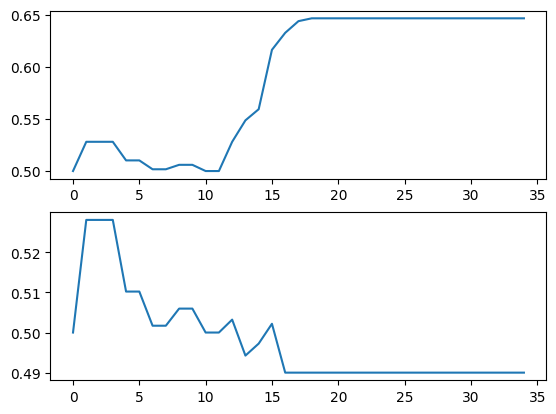

In [194]:
fig, axs = plt.subplots(nrows=2, ncols=1)

X = np.arange(len(train_roc_auc))

axs[0].plot(X, train_roc_auc)
axs[1].plot(X, val_roc_auc)

plt.plot()

In [191]:
min_smaples_splits = [i for i in range(0, 10)]

train_roc_auc = []
val_roc_auc = []

for mss in min_smaples_splits:
    my_clf = MyDecisionTreeClassifier(criterion='entropy', min_samples_split=mss, max_depth=5)
    my_clf.fit(X_train, y_train)
    train_roc_auc.append(roc_auc_score(y_train, my_clf.predict(X_train)))
    val_roc_auc.append(roc_auc_score(y_train, my_clf.predict(X_train)))

<ipython-input-149-fdb906225935>:78: RuntimeWarning: invalid value encountered in log2
  H = -np.sum((np.log2((l_class + 1e-6) / l_size) * (l_class + 1e-6) +


[]

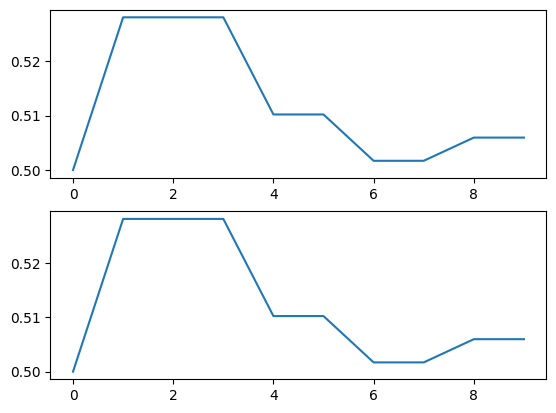

In [192]:
fig, axs = plt.subplots(nrows=2, ncols=1)

X = np.arange(len(train_roc_auc))

axs[0].plot(X, train_roc_auc)
axs[1].plot(X, val_roc_auc)

plt.plot()

Известным фактом является то, что деревья решений сильно переобучаются при увеличении глубины и просто запоминают трейн.
Замечаете ли вы такой эффект судя по графикам? Что при этом происходит с качеством на валидации?


Ответ: Судя по графикам глубины, переобучение начинается примерно с 16 шага. Качество на валидации падает, а качество на трейне выходит на плато.

## Находим самые важные признаки (2 балла)



По построенному дереву  легко понять, какие признаки лучше всего помогли решить задачу. Часто это бывает нужно  не только  для сокращения размерности в данных, но и для лучшего понимания прикладной задачи. Например, Вы хотите понять, какие признаки стоит еще конструировать -- для этого нужно понимать, какие из текущих лучше всего работают в дереве.

Самый простой метод -- посчитать число сплитов, где использовался данные признак. Это не лучший вариант, так как по признаку который принимает всего 2 значения, но который почти точно разделяет выборку, число сплитов будет очень 1, но при этом признак сам очень хороший.
В этом задании предлагается для каждого признака считать суммарный gain (в лекции обозначено как Q) при использовании этого признака в сплите. Тогда даже у очень хороших признаков с маленьким число сплитов это значение должно быть довольно высоким.  

Реализовать это довольно просто: создаете словарь номер фичи : суммарный гейн и добавляете в нужную фичу каждый раз, когда используете ее при построении дерева.

Добавьте функционал, который определяет значения feature importance. Обучите дерево на датасете Speed Dating Data.
Выведите 10 главных фичей по важности.

In [210]:
my_clf = MyDecisionTreeClassifier(criterion='entropy', min_samples_split=2, max_depth=depth)

my_clf.fit(X_train, y_train)

feat_imp = my_clf.get_feature_importance()
sorted_feat_imp = sorted(feat_imp.items(), key=lambda item: item[1].any())[:10]


In [217]:
for item in sorted_feat_imp:
    print(item[0])

8
4
0
20
49
46
35
1
51
54


## Фидбек (бесценно)

* Какие аспекты обучения деревьев решений Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ

